In [21]:
import pandas as pd
import numpy as np
import networkx as nx
from datetime import datetime
import matplotlib.pyplot as plt
from random import random

In [35]:
# Data reading
DATA_FOLDER = "Data/"

epinions = pd.read_table(DATA_FOLDER + 'soc-sign-epinions.txt', 
                         names=['Source','Target','Weight'],comment='#',header=None).rename_axis('Epinions',axis=1)
slashdot = pd.read_table(DATA_FOLDER + 'soc-sign-Slashdot090221.txt', 
                         names=['Source','Target','Weight'],comment='#',header=None).rename_axis('Slashdot',axis=1)
wikielec = pd.read_csv(DATA_FOLDER + 'wikipedia.csv').rename_axis('Wikipedia',axis=1)

In [36]:
# Display of the same structures datasets
display(epinions.head())
display(slashdot.head())
display(wikielec.head())

Epinions,Source,Target,Weight
0,0,1,-1
1,1,128552,-1
2,2,3,1
3,4,5,-1
4,4,155,-1


Slashdot,Source,Target,Weight
0,0,1,1
1,0,2,1
2,0,3,1
3,0,4,1
4,0,5,1


Wikipedia,Source,Target,Weight
0,3,30,1
1,25,30,-1
2,4,30,1
3,5,30,1
4,6,30,1


In [41]:
# Read nwetworkx
G_epinions = nx.from_pandas_edgelist(epinions, source="Source", target="Target", 
                            edge_attr=None, create_using=nx.DiGraph())
G_slashdot = nx.from_pandas_edgelist(epinions, source="Source", target="Target", 
                            edge_attr=None, create_using=nx.DiGraph())
G_wikielec = nx.from_pandas_edgelist(epinions, source="Source", target="Target", 
                            edge_attr=None, create_using=nx.DiGraph())

# PAUL

In [2]:
reddit  = pd.read_csv(DATA_FOLDER + "soc-redditHyperlinks-body.tsv", sep='\t')


In [3]:
reddit.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."


In [4]:
reddit["TIMESTAMP"] = pd.to_datetime(reddit["TIMESTAMP"])
reddit.rename(columns={"SOURCE_SUBREDDIT":"Source", "TARGET_SUBREDDIT":"Target", "LINK_SENTIMENT":"Weight", "TIMESTAMP":"Time"}, inplace=True)

In [5]:
reddit.shape

(286561, 6)

In [6]:
reddit[["Source","Target"]].duplicated().sum()

148740

In [7]:
reddit[["Source","Target","Weight","POST_ID"]].duplicated().sum()

0

In [8]:
reddit.duplicated().sum()

0

In [9]:
reddit[(reddit["Weight"] == -1)]["Target"].value_counts()

askreddit           892
worldnews           390
news                390
videos              373
pics                364
                   ... 
fatestaynight         1
spheremasterrace      1
chivalrygame          1
exurb1a               1
badselfeater          1
Name: Target, Length: 3907, dtype: int64

In [45]:
G = nx.from_pandas_edgelist(reddit, source="Source", target="Target", 
                            edge_attr=["Weight", "Time"], create_using=nx.DiGraph())

nb_pos = sum([w for (_,_,w) in G.edges.data("Weight") if w ==  1])
nb_neg = sum([w for (_,_,w) in G.edges.data("Weight") if w == -1])

for e in G.edges:
    G.edges[e]['Modified Weight'] = 1/nb_pos if G.edges[e]['Weight'] > 0 else 1/nb_neg
    
for node in G.nodes:
    out_edges_weight = [G.get_edge_data(*e)['Modified Weight'] for e in G.out_edges(node)]
    in_edges_weight  = [G.get_edge_data(*e)['Modified Weight'] for e in G.in_edges(node)]
    G.nodes[node]["Source score"] = np.mean(out_edges_weight) if len(out_edges_weight) > 0 else np.nan
    G.nodes[node]["Target score"] = np.mean(in_edges_weight)  if len(in_edges_weight)  > 0 else np.nan


for e in G.edges:
    s = G.nodes[e[0]]['Source score']
    t = G.nodes[e[1]]['Target score']
    if np.isnan(s) or np.isnan(t):
        raise ValueError("nan cannot exist")
        
    if s*t > 0:
        if s > 0:
            G.edges[e]["Predict"] = 1
        else:
            G.edges[e]["Predict"] = -1
            
    elif s*t < 0:
        if s > 0:
            if s > abs(t):
                G.edges[e]["Predict"] = 1
            elif s < abs(t):
                G.edges[e]["Predict"] = -1
            else:
                G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
        else:
            if abs(s) > t:
                G.edges[e]["Predict"] = -1
            elif abs(s) < t:
                G.edges[e]["Predict"] = 1
            else:
                G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)

    else:
        if s + t > 0:
            G.edges[e]["Predict"] = 1
        elif s + t < 0:
            G.edges[e]["Predict"] = -1
        else:
            G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)

TP = TN = FP = FN = 0
for e in G.edges:
    if G.edges[e]['Weight'] == G.edges[e]['Predict']:
        if G.edges[e]['Weight'] > 0:
            TP += 1
        else:
            TN += 1
    else:
        if G.edges[e]['Predict'] > 0:
            FP += 1
        else:
            FN += 1
            
print("TP: %d\nTN: %d\nFP: %d\nFN: %d\n"%(TP, TN, FP, FN))

TP: 90318
TN: 9131
FP: 508
FN: 37864



In [16]:
nb_neg

9639

In [ ]:
# First results:
# TP: 128177
# TN: 1437
# FP: 8202
# FN: 5

# Second results:
# TP: 90318
# TN: 9131
# FP: 508
# FN: 37864

# Third results:


<AxesSubplot:xlabel='TIMESTAMP'>

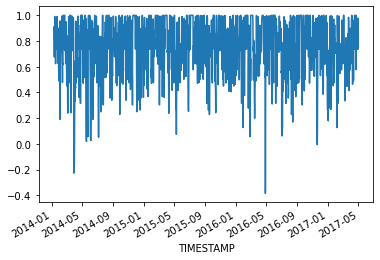

In [137]:
reddit[reddit["TARGET_SUBREDDIT"]=="askreddit"].sort_values("TIMESTAMP").set_index("TIMESTAMP")\
.LINK_SENTIMENT.rolling(window=50, win_type='gaussian').mean(std=3).plot()

In [2]:
with open(DATA_FOLDER + 'wiki-RfA.txt', 'r') as f:
    lines = f.read().splitlines()
# Remove empty string
lines = list(filter(None, lines))

In [3]:
d = {'SRC': [], 'TGT': [], 'VOT': [], 'RES': [], 'YEA': [], 'DAT': [], 'TXT': [],}
for line in lines:
    d[line[:3]].append(line[4:])

In [4]:
wikirfa = pd.DataFrame(data=d)

In [5]:
wikirfa.head()

,SRC,TGT,VOT,RES,YEA,DAT,TXT
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit..."


In [6]:
wikirfa.shape

(198275, 7)

In [7]:
wikirfa[["SRC", "TGT", "VOT", "DAT"]].duplicated().sum()

1678

In [59]:
wikirfa.drop_duplicates(subset=["SRC", "TGT"], inplace=True)

In [8]:
198275-9272

189003

In [9]:
wikirfa["DAT"][6821]='14:47, 1 July 2012'
wikirfa["DAT"][27608]='20:44, 3 January 2010'
wikirfa["DAT"][70591]='21:29, 24 May 2008'
wikirfa["DAT"][116963]='17:44, 26 May 2007'

wikirfa["DAT"] = pd.to_datetime(wikirfa["DAT"])

In [32]:
wikirfa.duplicated().sum()

554

In [60]:
wikirfa[wikirfa["TGT"]=="Everyking"]

,SRC,TGT,VOT,RES,YEA,DAT,TXT
21019,Antandrus,Everyking,1,1,2010,2010-01-18 21:25:00,'''Support''' as nominator; with pleasure.
21020,Icewedge,Everyking,1,1,2010,2010-01-18 22:17:00,"'''Support''' I supported last time, and I wil..."
21021,Soap,Everyking,1,1,2010,2010-01-18 22:32:00,'''Support''' per my !vote on [[Wikipedia:Requ...
21022,Cool Hand Luke,Everyking,1,1,2010,2010-01-18 22:36:00,'''Support'''. I am impressed by Everyking's c...
21023,Sbharris,Everyking,1,1,2010,2010-01-18 22:43:00,"'''Support''' Gone beyond a joke, you guys. An..."
...,...,...,...,...,...,...,...
192901,Infrogmation,Everyking,1,1,2004,2004-05-06 05:59:00,
192902,Rhymeless,Everyking,1,1,2004,2004-05-06 06:20:00,
192903,Bcorr,Everyking,1,1,2004,NaT,
192904,Jengod,Everyking,1,1,2004,NaT,


<AxesSubplot:xlabel='DAT'>

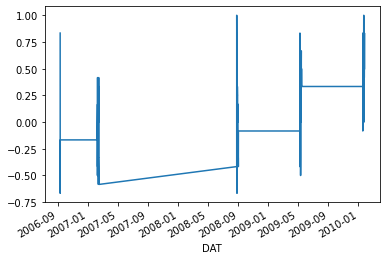

In [118]:
wikirfa[wikirfa["TGT"]=="Everyking"].sort_values("DAT").set_index("DAT").VOT.astype(int).rolling(window=12).mean().plot()

<AxesSubplot:>

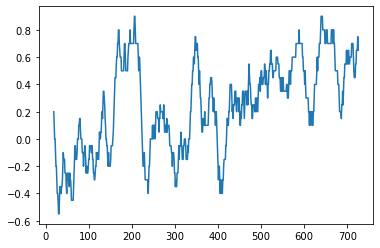

In [94]:
wikirfa[wikirfa["TGT"]=="Everyking"].sort_values("DAT").VOT.astype(int).reset_index(drop=True).rolling(window=20).mean().plot()

In [29]:
wikirfa[wikirfa["TGT"]=="Everyking"][["SRC", "TGT"]].duplicated().sum()

261

In [19]:
G = nx.from_pandas_edgelist(wikirfa, source="SRC", target="TGT", edge_attr=["VOT", "DAT"], create_using=nx.DiGraph())

In [20]:
sorted(G.in_degree, key=lambda x: x[1], reverse=True)

[('Everyking', 726),
 ('TenPoundHammer', 534),
 ('MZMcBride', 518),
 ('Elonka', 491),
 ('Werdna', 485),
 ('Cobi', 458),
 ('Ironholds', 444),
 ('Enigmaman', 379),
 ('Kww', 375),
 ('The Transhumanist', 356),
 ('Majorly', 356),
 ("Can't sleep, clown will eat me", 354),
 ('MONGO', 351),
 ('HJ Mitchell', 339),
 ('Robchurch', 324),
 ('SarekOfVulcan', 318),
 ('Siva1979', 318),
 ('Carnildo', 304),
 ('PeterSymonds', 289),
 ('Geni', 286),
 ('VanTucky', 286),
 ('Ryulong', 284),
 ('Herostratus', 277),
 ('Phaedriel', 277),
 ('Crzrussian', 277),
 ('Gracenotes', 276),
 ('Thumperward', 274),
 ('Master of Puppets', 264),
 ('Sean Black', 262),
 ('Nev1', 259),
 ('Ceranthor', 255),
 ('BQZip01', 253),
 ('Badlydrawnjeff', 250),
 ('MER-C', 246),
 ('Betacommand', 243),
 ('The Thing That Should Not Be', 242),
 ('Connormah', 237),
 ('ProtectionBot', 237),
 ('Addshore', 234),
 ('^demon', 232),
 ('JamieS93', 229),
 ('Newyorkbrad', 227),
 ("Milk's Favorite Cookie", 226),
 ('Epbr123', 224),
 ('FlyingToaster', 223),

In [21]:
G['Everyking']

AtlasView({'Basalisk': {'VOT': '-1', 'DAT': Timestamp('2012-11-22 01:48:00')}, 'SarahStierch': {'VOT': '1', 'DAT': Timestamp('2012-07-27 13:43:00')}, 'Bwilkins': {'VOT': '1', 'DAT': Timestamp('2010-01-23 05:42:00')}, 'Ceranthor': {'VOT': '1', 'DAT': Timestamp('2010-04-23 05:33:00')}, 'Leonard^Bloom': {'VOT': '1', 'DAT': Timestamp('2010-01-23 05:37:00')}, 'Ironholds': {'VOT': '-1', 'DAT': Timestamp('2010-01-02 17:51:00')}, 'Sam Blacketer': {'VOT': '-1', 'DAT': Timestamp('2010-01-04 06:43:00')}, 'FlyingToaster': {'VOT': '1', 'DAT': Timestamp('2009-05-17 20:31:00')}, 'Hawkeye7': {'VOT': '1', 'DAT': Timestamp('2009-11-13 03:46:00')}, 'Orlady': {'VOT': '1', 'DAT': Timestamp('2009-04-10 14:45:00')}, 'Baseball Bugs': {'VOT': '-1', 'DAT': Timestamp('2009-03-11 17:27:00')}, 'Katerenka': {'VOT': '1', 'DAT': Timestamp('2009-10-27 23:40:00')}, 'Kww': {'VOT': '-1', 'DAT': Timestamp('2009-10-12 05:01:00')}, 'Majorly': {'VOT': '1', 'DAT': Timestamp('2007-11-05 04:47:00')}, 'Ottava Rima': {'VOT': '-1'

In [46]:
G = nx.DiGraph(name="Wiki-RFA")
G.add_weighted_edges_from(map(tuple, wikirfa[["SRC", "TGT", "VOT"]].values))

In [47]:
print(nx.info(G))

Name: Wiki-RFA
Type: DiGraph
Number of nodes: 11381
Number of edges: 189003
Average in degree:  16.6069
Average out degree:  16.6069


In [53]:
(wikirfa["VOT"]=='1').sum()

144451

In [81]:
wikirfa["DAT"] = pd.to_datetime(wikirfa["DAT"])

In [75]:
wikirfa["DAT"][198272]

''

In [79]:
(wikirfa["DAT"]=='').sum()

9367

In [85]:
wikirfa["DAT"][0]-wikirfa["DAT"][1]

Timedelta('-1 days +22:09:00')

In [130]:
(wikirfa["TGT"]=='Everyking').sum()

987

In [146]:
pd.to_datetime(wikirfa['DAT']).to_dict()

{0: Timestamp('2013-04-19 23:13:00'),
 1: Timestamp('2013-04-20 01:04:00'),
 2: Timestamp('2013-04-19 23:43:00'),
 3: Timestamp('2013-04-20 00:11:00'),
 4: Timestamp('2013-04-20 00:56:00'),
 5: Timestamp('2013-04-20 01:53:00'),
 6: Timestamp('2013-04-20 02:00:00'),
 7: Timestamp('2013-04-20 02:18:00'),
 8: Timestamp('2013-04-20 02:22:00'),
 9: Timestamp('2013-04-20 03:09:00'),
 10: Timestamp('2013-04-20 03:18:00'),
 11: Timestamp('2013-04-20 03:20:00'),
 12: Timestamp('2013-04-20 03:25:00'),
 13: Timestamp('2013-04-20 03:28:00'),
 14: Timestamp('2013-04-20 03:39:00'),
 15: Timestamp('2013-04-20 04:49:00'),
 16: Timestamp('2013-04-20 07:04:00'),
 17: Timestamp('2013-04-20 11:08:00'),
 18: Timestamp('2013-04-20 14:26:00'),
 19: Timestamp('2013-04-20 15:27:00'),
 20: Timestamp('2013-04-20 15:51:00'),
 21: Timestamp('2013-04-20 16:35:00'),
 22: Timestamp('2013-04-20 16:53:00'),
 23: Timestamp('2013-04-20 17:08:00'),
 24: Timestamp('2013-04-20 17:47:00'),
 25: Timestamp('2013-04-20 18:37:00

In [142]:
nx.set_node_attributes(G, pd.to_datetime(wikirfa['DAT']).to_dict(), 'Date' )

In [143]:
G.nodes["Everyking"]

{}

In [145]:
print(nx.info(G))

Name: Wiki-RFA
Type: DiGraph
Number of nodes: 11381
Number of edges: 189003
Average in degree:  16.6069
Average out degree:  16.6069


In [119]:
datetime.strptime(wikirfa["DAT"][0], '%H:%M, %d %B %Y')

datetime.datetime(2013, 4, 19, 23, 13)

In [127]:
for date in wikirfa["DAT"]:
    if date != "":
        try:
            datetime.strptime(date, '%H:%M, %d %B %Y')
        except:
            continue
        try:
            datetime.strptime(date, '%H:%M, %d %b %Y')
        except:
            continue
            
        print(date)
    

00:37, 25 May 2013
00:46, 25 May 2013
01:01, 25 May 2013
01:03, 25 May 2013
01:06, 25 May 2013
01:17, 25 May 2013
01:42, 25 May 2013
01:48, 25 May 2013
01:51, 25 May 2013
02:27, 25 May 2013
03:01, 25 May 2013
03:19, 25 May 2013
03:23, 25 May 2013
03:26, 25 May 2013
04:07, 25 May 2013
04:46, 25 May 2013
05:30, 25 May 2013
06:38, 25 May 2013
06:50, 25 May 2013
07:11, 25 May 2013
07:58, 25 May 2013
08:33, 25 May 2013
08:54, 25 May 2013
08:58, 25 May 2013
11:10, 25 May 2013
11:28, 25 May 2013
12:36, 25 May 2013
15:03, 25 May 2013
15:06, 25 May 2013
15:22, 25 May 2013
15:25, 25 May 2013
15:38, 25 May 2013
15:49, 25 May 2013
16:06, 25 May 2013
18:10, 25 May 2013
18:20, 25 May 2013
18:42, 25 May 2013
18:45, 25 May 2013
19:15, 25 May 2013
19:50, 25 May 2013
20:11, 25 May 2013
20:24, 25 May 2013
20:59, 25 May 2013
22:23, 25 May 2013
23:50, 25 May 2013
02:25, 26 May 2013
05:06, 26 May 2013
06:23, 26 May 2013
09:04, 26 May 2013
09:25, 26 May 2013
09:38, 26 May 2013
09:41, 26 May 2013
10:03, 26 Ma

23:23, 17 May 2012
02:00, 18 May 2012
03:45, 18 May 2012
04:22, 18 May 2012
05:06, 18 May 2012
06:05, 18 May 2012
06:18, 18 May 2012
08:58, 18 May 2012
10:14, 18 May 2012
12:04, 18 May 2012
14:31, 18 May 2012
17:26, 18 May 2012
20:36, 18 May 2012
22:08, 18 May 2012
22:25, 18 May 2012
02:33, 19 May 2012
15:23, 17 May 2012
16:02, 17 May 2012
17:24, 17 May 2012
21:36, 17 May 2012
06:13, 18 May 2012
10:53, 18 May 2012
11:34, 18 May 2012
14:01, 18 May 2012
14:06, 18 May 2012
20:11, 18 May 2012
00:57, 1 May 2012
02:02, 1 May 2012
02:48, 1 May 2012
02:49, 1 May 2012
14:01, 1 May 2012
07:43, 1 May 2012
03:39, 1 May 2012
15:53, 1 May 2012
00:27, 1 May 2012
00:50, 1 May 2012
01:05, 1 May 2012
01:27, 1 May 2012
02:14, 1 May 2012
02:41, 1 May 2012
02:46, 1 May 2012
07:09, 1 May 2012
07:35, 1 May 2012
13:07, 1 May 2012
13:10, 1 May 2012
17:59, 1 May 2012
00:48, 1 May 2012
06:22, 1 May 2012
07:03, 1 May 2012
08:50, 1 May 2012
14:22, 1 May 2012
10:14, 19 May 2012
10:18, 19 May 2012
10:21, 19 May 2012

21:31, 3 May 2011
21:57, 3 May 2011
00:49, 4 May 2011
02:02, 4 May 2011
04:39, 4 May 2011
06:20, 4 May 2011
09:16, 4 May 2011
17:27, 4 May 2011
17:59, 4 May 2011
21:02, 4 May 2011
23:04, 4 May 2011
02:41, 5 May 2011
04:35, 5 May 2011
12:21, 5 May 2011
15:19, 5 May 2011
21:39, 5 May 2011
00:02, 6 May 2011
01:41, 6 May 2011
03:03, 6 May 2011
05:32, 6 May 2011
11:14, 6 May 2011
13:26, 6 May 2011
23:26, 6 May 2011
01:23, 7 May 2011
02:43, 7 May 2011
03:25, 7 May 2011
21:48, 7 May 2011
22:46, 7 May 2011
00:10, 8 May 2011
03:26, 8 May 2011
07:23, 8 May 2011
08:54, 8 May 2011
11:20, 8 May 2011
21:26, 8 May 2011
22:40, 8 May 2011
22:47, 8 May 2011
22:56, 8 May 2011
23:48, 8 May 2011
00:09, 9 May 2011
03:13, 9 May 2011
08:27, 9 May 2011
17:00, 9 May 2011
17:27, 9 May 2011
17:38, 9 May 2011
21:37, 9 May 2011
00:28, 10 May 2011
02:17, 10 May 2011
13:00, 3 May 2011
17:43, 3 May 2011
20:32, 3 May 2011
21:37, 3 May 2011
02:27, 5 May 2011
17:34, 5 May 2011
08:29, 6 May 2011
18:07, 8 May 2011
19:28, 8

00:33, 1 May 2010
13:18, 1 May 2010
15:56, 1 May 2010
18:57, 1 May 2010
20:27, 1 May 2010
21:31, 1 May 2010
21:37, 1 May 2010
22:42, 1 May 2010
03:10, 2 May 2010
03:47, 2 May 2010
19:05, 2 May 2010
19:19, 2 May 2010
23:26, 2 May 2010
23:50, 2 May 2010
23:55, 2 May 2010
00:33, 3 May 2010
00:55, 3 May 2010
03:43, 1 May 2010
18:30, 2 May 2010
21:03, 2 May 2010
22:52, 12 May 2010
23:40, 12 May 2010
23:41, 12 May 2010
23:42, 12 May 2010
23:47, 12 May 2010
23:49, 12 May 2010
23:52, 12 May 2010
23:54, 12 May 2010
23:56, 12 May 2010
00:01, 13 May 2010
00:08, 13 May 2010
00:10, 13 May 2010
00:21, 13 May 2010
00:23, 13 May 2010
00:28, 13 May 2010
00:33, 13 May 2010
00:37, 13 May 2010
00:41, 13 May 2010
00:47, 13 May 2010
00:57, 13 May 2010
00:59, 13 May 2010
01:00, 13 May 2010
01:02, 13 May 2010
01:04, 13 May 2010
01:11, 13 May 2010
01:17, 13 May 2010
01:19, 13 May 2010
01:31, 13 May 2010
01:33, 13 May 2010
01:38, 13 May 2010
01:53, 13 May 2010
02:02, 13 May 2010
02:40, 13 May 2010
02:50, 13 May

19:27, 24 May 2009
19:49, 24 May 2009
20:50, 24 May 2009
22:43, 24 May 2009
00:01, 25 May 2009
00:03, 25 May 2009
01:13, 25 May 2009
02:23, 25 May 2009
03:54, 25 May 2009
04:51, 25 May 2009
08:11, 25 May 2009
12:54, 25 May 2009
14:36, 25 May 2009
15:28, 25 May 2009
15:29, 25 May 2009
17:16, 25 May 2009
17:25, 25 May 2009
19:42, 25 May 2009
19:47, 25 May 2009
19:50, 25 May 2009
00:15, 26 May 2009
00:23, 26 May 2009
00:46, 26 May 2009
01:28, 26 May 2009
01:55, 26 May 2009
03:33, 26 May 2009
04:20, 26 May 2009
04:25, 26 May 2009
07:53, 26 May 2009
11:00, 26 May 2009
13:34, 26 May 2009
13:57, 26 May 2009
14:27, 26 May 2009
16:03, 26 May 2009
18:02, 26 May 2009
18:36, 26 May 2009
19:41, 26 May 2009
19:58, 26 May 2009
20:29, 26 May 2009
22:19, 26 May 2009
08:26, 27 May 2009
13:08, 27 May 2009
13:58, 27 May 2009
21:04, 27 May 2009
02:36, 28 May 2009
04:52, 28 May 2009
05:11, 28 May 2009
17:30, 28 May 2009
00:04, 29 May 2009
05:09, 29 May 2009
19:15, 29 May 2009
21:42, 29 May 2009
22:42, 29 Ma

17:07, 5 May 2009
17:29, 5 May 2009
17:30, 5 May 2009
17:39, 5 May 2009
17:57, 5 May 2009
18:01, 5 May 2009
18:06, 5 May 2009
18:08, 5 May 2009
18:09, 5 May 2009
18:15, 5 May 2009
18:23, 5 May 2009
18:26, 5 May 2009
18:28, 5 May 2009
18:30, 5 May 2009
18:34, 5 May 2009
18:35, 5 May 2009
18:38, 5 May 2009
18:55, 5 May 2009
19:12, 5 May 2009
19:15, 5 May 2009
19:37, 5 May 2009
19:45, 5 May 2009
19:45, 5 May 2009
19:46, 5 May 2009
19:48, 5 May 2009
20:40, 5 May 2009
20:40, 5 May 2009
21:15, 5 May 2009
21:34, 5 May 2009
22:28, 5 May 2009
22:33, 5 May 2009
22:38, 5 May 2009
22:40, 5 May 2009
01:34, 6 May 2009
02:32, 6 May 2009
02:46, 6 May 2009
04:18, 6 May 2009
05:15, 6 May 2009
05:17, 6 May 2009
06:15, 6 May 2009
09:34, 6 May 2009
10:34, 6 May 2009
12:18, 6 May 2009
15:46, 6 May 2009
18:35, 6 May 2009
19:12, 6 May 2009
22:35, 6 May 2009
03:45, 7 May 2009
04:09, 7 May 2009
14:16, 7 May 2009
14:49, 7 May 2009
19:35, 7 May 2009
19:37, 7 May 2009
16:02, 8 May 2009
22:34, 8 May 2009
02:10, 9 M

22:50, 26 May 2009
22:51, 26 May 2009
22:52, 26 May 2009
22:54, 26 May 2009
23:06, 26 May 2009
23:07, 26 May 2009
23:09, 26 May 2009
23:09, 26 May 2009
23:12, 26 May 2009
23:16, 26 May 2009
23:17, 26 May 2009
23:18, 26 May 2009
23:24, 26 May 2009
23:25, 26 May 2009
23:27, 26 May 2009
23:35, 26 May 2009
23:36, 26 May 2009
00:09, 27 May 2009
00:15, 27 May 2009
00:19, 27 May 2009
00:23, 27 May 2009
00:32, 27 May 2009
00:33, 27 May 2009
00:43, 27 May 2009
00:48, 27 May 2009
00:56, 27 May 2009
01:01, 27 May 2009
01:11, 27 May 2009
01:21, 27 May 2009
01:36, 27 May 2009
01:45, 27 May 2009
02:14, 27 May 2009
02:15, 27 May 2009
04:36, 27 May 2009
05:22, 27 May 2009
05:26, 27 May 2009
05:33, 27 May 2009
05:41, 27 May 2009
05:57, 27 May 2009
06:00, 27 May 2009
06:14, 27 May 2009
06:55, 27 May 2009
08:45, 27 May 2009
09:50, 27 May 2009
09:54, 27 May 2009
09:59, 27 May 2009
10:06, 27 May 2009
10:19, 27 May 2009
11:32, 27 May 2009
11:39, 27 May 2009
12:40, 27 May 2009
13:46, 27 May 2009
13:53, 27 Ma

01:47, 18 May 2008
01:52, 18 May 2008
01:53, 18 May 2008
01:55, 18 May 2008
01:57, 18 May 2008
01:57, 18 May 2008
02:01, 18 May 2008
02:03, 18 May 2008
02:11, 18 May 2008
02:14, 18 May 2008
02:21, 18 May 2008
02:39, 18 May 2008
02:43, 18 May 2008
03:30, 18 May 2008
03:33, 18 May 2008
03:34, 18 May 2008
03:42, 18 May 2008
04:21, 18 May 2008
05:33, 18 May 2008
05:40, 18 May 2008
06:46, 18 May 2008
06:50, 18 May 2008
06:55, 18 May 2008
07:19, 18 May 2008
07:27, 18 May 2008
07:33, 18 May 2008
10:15, 18 May 2008
10:26, 18 May 2008
10:50, 18 May 2008
11:52, 18 May 2008
12:11, 18 May 2008
12:25, 18 May 2008
12:39, 18 May 2008
12:52, 18 May 2008
12:54, 18 May 2008
13:09, 18 May 2008
16:43, 18 May 2008
17:25, 18 May 2008
19:16, 18 May 2008
19:31, 18 May 2008
20:17, 18 May 2008
20:23, 18 May 2008
21:14, 18 May 2008
21:45, 18 May 2008
22:18, 18 May 2008
22:44, 18 May 2008
23:06, 18 May 2008
23:59, 18 May 2008
00:39, 19 May 2008
08:42, 19 May 2008
08:51, 19 May 2008
11:51, 19 May 2008
12:46, 19 Ma

22:05, 16 May 2008
22:07, 16 May 2008
22:12, 16 May 2008
22:16, 16 May 2008
22:18, 16 May 2008
22:19, 16 May 2008
22:21, 16 May 2008
22:24, 16 May 2008
22:40, 16 May 2008
23:21, 16 May 2008
23:41, 16 May 2008
23:47, 16 May 2008
00:08, 17 May 2008
00:23, 17 May 2008
00:32, 17 May 2008
02:40, 17 May 2008
03:10, 17 May 2008
04:33, 17 May 2008
05:39, 17 May 2008
05:42, 17 May 2008
07:32, 17 May 2008
07:33, 17 May 2008
09:20, 17 May 2008
10:09, 17 May 2008
10:33, 17 May 2008
12:56, 17 May 2008
13:14, 17 May 2008
13:47, 17 May 2008
13:49, 17 May 2008
14:11, 17 May 2008
16:44, 17 May 2008
17:02, 17 May 2008
17:03, 17 May 2008
17:16, 17 May 2008
22:28, 17 May 2008
23:05, 17 May 2008
00:36, 18 May 2008
01:11, 18 May 2008
02:21, 18 May 2008
03:35, 18 May 2008
07:16, 18 May 2008
10:19, 18 May 2008
13:53, 18 May 2008
22:37, 18 May 2008
23:00, 18 May 2008
23:44, 18 May 2008
00:49, 19 May 2008
10:52, 19 May 2008
12:20, 19 May 2008
16:08, 19 May 2008
17:34, 19 May 2008
18:59, 19 May 2008
11:13, 20 Ma

08:42, 10 May 2008
17:01, 10 May 2008
19:12, 10 May 2008
21:12, 10 May 2008
22:11, 12 May 2008
23:27, 12 May 2008
23:34, 12 May 2008
08:49, 13 May 2008
11:07, 13 May 2008
00:49, 14 May 2008
01:18, 14 May 2008
01:23, 14 May 2008
03:21, 7 May 2008
06:26, 7 May 2008
07:15, 7 May 2008
07:22, 7 May 2008
07:25, 7 May 2008
11:53, 7 May 2008
12:29, 7 May 2008
12:43, 7 May 2008
14:47, 7 May 2008
16:12, 7 May 2008
17:26, 7 May 2008
21:26, 7 May 2008
19:07, 7 May 2008
19:41, 7 May 2008
19:42, 7 May 2008
20:21, 7 May 2008
20:25, 7 May 2008
20:37, 7 May 2008
20:53, 7 May 2008
20:59, 7 May 2008
21:34, 7 May 2008
21:50, 7 May 2008
01:23, 8 May 2008
04:16, 8 May 2008
06:49, 8 May 2008
09:04, 8 May 2008
09:15, 8 May 2008
17:38, 8 May 2008
21:42, 8 May 2008
03:30, 9 May 2008
05:22, 9 May 2008
09:59, 9 May 2008
14:18, 9 May 2008
15:05, 9 May 2008
21:24, 9 May 2008
22:15, 9 May 2008
12:16, 10 May 2008
12:39, 10 May 2008
13:30, 10 May 2008
16:46, 11 May 2008
05:27, 12 May 2008
00:29, 13 May 2008
14:20, 13 

17:58, 27 May 2008
16:17, 27 May 2008
16:21, 27 May 2008
16:24, 27 May 2008
16:28, 27 May 2008
16:28, 27 May 2008
16:34, 27 May 2008
17:03, 27 May 2008
17:05, 27 May 2008
17:18, 27 May 2008
17:19, 27 May 2008
17:44, 27 May 2008
17:51, 27 May 2008
18:03, 27 May 2008
18:54, 27 May 2008
19:01, 27 May 2008
19:03, 27 May 2008
20:50, 27 May 2008
20:51, 27 May 2008
20:52, 27 May 2008
21:05, 27 May 2008
21:14, 27 May 2008
21:53, 27 May 2008
22:01, 27 May 2008
22:15, 27 May 2008
16:07, 27 May 2008
17:09, 27 May 2008
18:09, 27 May 2008
19:33, 27 May 2008
14:14, 29 May 2008
14:24, 29 May 2008
14:34, 29 May 2008
14:56, 29 May 2008
14:57, 29 May 2008
15:22, 29 May 2008
15:30, 29 May 2008
15:49, 29 May 2008
14:06, 29 May 2008
15:23, 29 May 2008
19:24, 22 May 2008
17:41, 8 May 2008
17:45, 8 May 2008
17:59, 8 May 2008
16:18, 8 May 2008
16:40, 8 May 2008
16:50, 8 May 2008
17:08, 8 May 2008
17:23, 8 May 2008
17:26, 8 May 2008
17:34, 8 May 2008
17:35, 8 May 2008
17:57, 8 May 2008
18:21, 8 May 2008
18:27,

23:04, 31 May 2007
23:52, 31 May 2007
23:55, 31 May 2007
23:26, 5 May 2007
23:31, 5 May 2007
23:34, 5 May 2007
23:38, 5 May 2007
23:41, 5 May 2007
23:53, 5 May 2007
00:18, 6 May 2007
00:20, 6 May 2007
01:14, 6 May 2007
01:52, 6 May 2007
02:01, 6 May 2007
03:03, 6 May 2007
05:24, 6 May 2007
06:22, 6 May 2007
06:49, 6 May 2007
07:34, 6 May 2007
08:47, 6 May 2007
09:39, 6 May 2007
10:04, 6 May 2007
11:18, 6 May 2007
13:30, 6 May 2007
13:48, 6 May 2007
14:03, 6 May 2007
14:25, 6 May 2007
15:02, 6 May 2007
16:10, 6 May 2007
16:31, 6 May 2007
16:37, 6 May 2007
17:35, 6 May 2007
18:01, 6 May 2007
18:15, 6 May 2007
18:24, 6 May 2007
18:33, 6 May 2007
19:49, 6 May 2007
20:29, 6 May 2007
21:47, 6 May 2007
22:34, 6 May 2007
23:06, 6 May 2007
00:52, 7 May 2007
01:22, 7 May 2007
01:49, 7 May 2007
02:50, 7 May 2007
09:17, 7 May 2007
12:08, 7 May 2007
14:13, 7 May 2007
16:34, 7 May 2007
17:50, 7 May 2007
19:47, 7 May 2007
22:47, 7 May 2007
01:45, 8 May 2007
04:53, 8 May 2007
11:15, 8 May 2007
23:25, 

07:01, 22 May 2007
07:03, 22 May 2007
07:10, 22 May 2007
07:17, 22 May 2007
07:17, 22 May 2007
07:25, 22 May 2007
07:28, 22 May 2007
07:32, 22 May 2007
07:35, 22 May 2007
07:37, 22 May 2007
07:51, 22 May 2007
07:55, 22 May 2007
08:19, 22 May 2007
08:28, 22 May 2007
08:32, 22 May 2007
08:38, 22 May 2007
09:08, 22 May 2007
09:16, 22 May 2007
09:49, 22 May 2007
11:28, 22 May 2007
11:34, 22 May 2007
11:41, 22 May 2007
11:46, 22 May 2007
12:02, 22 May 2007
12:10, 22 May 2007
12:29, 22 May 2007
12:44, 22 May 2007
13:05, 22 May 2007
13:22, 22 May 2007
13:45, 22 May 2007
13:50, 22 May 2007
14:14, 22 May 2007
14:28, 22 May 2007
14:43, 22 May 2007
14:47, 22 May 2007
15:09, 22 May 2007
15:43, 22 May 2007
15:56, 22 May 2007
16:03, 22 May 2007
16:28, 22 May 2007
16:30, 22 May 2007
16:38, 22 May 2007
18:03, 22 May 2007
18:08, 22 May 2007
18:28, 22 May 2007
18:30, 22 May 2007
18:32, 22 May 2007
18:42, 22 May 2007
19:14, 22 May 2007
19:21, 22 May 2007
19:36, 22 May 2007
20:01, 22 May 2007
20:02, 22 Ma

21:13, 1 May 2007
21:17, 1 May 2007
21:36, 1 May 2007
22:22, 1 May 2007
01:37, 2 May 2007
06:38, 2 May 2007
06:40, 2 May 2007
06:55, 2 May 2007
07:20, 2 May 2007
07:25, 2 May 2007
08:14, 2 May 2007
08:54, 2 May 2007
09:13, 2 May 2007
09:23, 2 May 2007
10:35, 2 May 2007
10:41, 2 May 2007
10:45, 2 May 2007
10:47, 2 May 2007
11:06, 2 May 2007
13:39, 2 May 2007
15:30, 2 May 2007
16:52, 2 May 2007
16:59, 2 May 2007
17:18, 2 May 2007
18:35, 2 May 2007
20:52, 2 May 2007
22:46, 2 May 2007
00:53, 3 May 2007
01:38, 3 May 2007
03:26, 3 May 2007
07:16, 3 May 2007
10:28, 3 May 2007
15:32, 3 May 2007
16:47, 3 May 2007
17:58, 3 May 2007
22:37, 3 May 2007
23:06, 3 May 2007
23:27, 3 May 2007
01:23, 4 May 2007
01:28, 4 May 2007
03:33, 4 May 2007
06:49, 4 May 2007
11:36, 4 May 2007
12:32, 4 May 2007
14:50, 4 May 2007
15:00, 4 May 2007
16:27, 4 May 2007
16:33, 4 May 2007
00:39, 5 May 2007
18:38, 5 May 2007
21:39, 5 May 2007
22:44, 5 May 2007
01:22, 6 May 2007
18:35, 6 May 2007
22:06, 6 May 2007
12:08, 7 M

18:58, 30 May 2007
19:03, 30 May 2007
19:38, 30 May 2007
19:44, 30 May 2007
03:03, 13 May 2007
04:29, 13 May 2007
22:31, 13 May 2007
05:05, 13 May 2007
08:38, 13 May 2007
09:55, 13 May 2007
11:33, 13 May 2007
14:56, 13 May 2007
17:02, 13 May 2007
17:41, 13 May 2007
18:32, 13 May 2007
22:21, 13 May 2007
03:56, 14 May 2007
10:09, 14 May 2007
17:24, 14 May 2007
20:46, 14 May 2007
23:50, 14 May 2007
06:42, 13 May 2007
13:43, 13 May 2007
14:04, 13 May 2007
04:20, 14 May 2007
04:55, 31 May 2007
17:56, 4 May 2007
18:03, 4 May 2007
18:17, 4 May 2007
19:43, 4 May 2007
20:49, 4 May 2007
21:39, 4 May 2007
21:40, 4 May 2007
22:25, 4 May 2007
22:31, 4 May 2007
22:41, 4 May 2007
23:26, 4 May 2007
23:57, 4 May 2007
00:35, 5 May 2007
01:19, 5 May 2007
22:03, 4 May 2007
01:28, 17 May 2007
01:43, 17 May 2007
13:46, 17 May 2007
13:49, 17 May 2007
13:52, 17 May 2007
14:01, 17 May 2007
22:32, 3 May 2007
22:47, 3 May 2007
22:09, 3 May 2007
22:11, 3 May 2007
22:22, 3 May 2007
22:36, 3 May 2007
22:54, 3 May 2

15:28, 27 May 2006
17:12, 27 May 2006
19:30, 27 May 2006
02:07, 28 May 2006
02:23, 28 May 2006
02:25, 28 May 2006
02:54, 28 May 2006
06:27, 28 May 2006
12:20, 28 May 2006
19:36, 28 May 2006
20:32, 28 May 2006
17:48, 22 May 2006
03:11, 29 May 2006
00:05, 20 May 2006
00:07, 20 May 2006
00:07, 20 May 2006
00:08, 20 May 2006
00:10, 20 May 2006
00:11, 20 May 2006
00:13, 20 May 2006
00:14, 20 May 2006
00:23, 20 May 2006
00:25, 20 May 2006
00:57, 20 May 2006
00:59, 20 May 2006
01:01, 20 May 2006
01:04, 20 May 2006
01:09, 20 May 2006
01:13, 20 May 2006
01:14, 20 May 2006
01:18, 20 May 2006
01:30, 20 May 2006
01:45, 20 May 2006
01:48, 20 May 2006
01:57, 20 May 2006
02:02, 20 May 2006
02:20, 20 May 2006
02:24, 20 May 2006
03:05, 20 May 2006
03:07, 20 May 2006
03:39, 20 May 2006
04:04, 20 May 2006
04:17, 20 May 2006
04:25, 20 May 2006
04:33, 20 May 2006
04:45, 20 May 2006
04:46, 20 May 2006
05:28, 20 May 2006
05:47, 20 May 2006
06:34, 20 May 2006
06:44, 20 May 2006
07:06, 20 May 2006
07:10, 20 Ma

04:30, 6 May 2006
14:47, 6 May 2006
18:18, 6 May 2006
03:24, 7 May 2006
12:09, 7 May 2006
13:12, 7 May 2006
15:23, 7 May 2006
20:44, 7 May 2006
21:01, 7 May 2006
22:25, 7 May 2006
22:29, 7 May 2006
23:52, 7 May 2006
02:08, 8 May 2006
02:55, 8 May 2006
03:41, 8 May 2006
11:22, 1 May 2006
12:38, 1 May 2006
10:42, 3 May 2006
19:22, 3 May 2006
17:33, 5 May 2006
14:37, 1 May 2006
17:09, 1 May 2006
01:22, 3 May 2006
18:12, 6 May 2006
12:39, 18 May 2006
12:57, 18 May 2006
13:11, 18 May 2006
13:16, 18 May 2006
13:29, 18 May 2006
13:31, 18 May 2006
14:05, 18 May 2006
14:06, 18 May 2006
14:12, 18 May 2006
14:27, 18 May 2006
14:29, 18 May 2006
15:57, 18 May 2006
16:24, 18 May 2006
16:47, 18 May 2006
17:03, 18 May 2006
17:14, 18 May 2006
19:15, 18 May 2006
19:32, 18 May 2006
19:35, 18 May 2006
22:21, 18 May 2006
23:20, 18 May 2006
23:36, 18 May 2006
00:57, 19 May 2006
01:08, 19 May 2006
01:17, 19 May 2006
01:32, 19 May 2006
02:46, 19 May 2006
06:59, 19 May 2006
12:03, 19 May 2006
14:22, 19 May 200

01:12, 1 May 2006
01:14, 1 May 2006
01:27, 1 May 2006
05:29, 1 May 2006
10:56, 1 May 2006
17:43, 1 May 2006
07:37, 2 May 2006
12:33, 2 May 2006
15:13, 2 May 2006
18:37, 2 May 2006
11:12, 3 May 2006
12:26, 3 May 2006
13:35, 3 May 2006
16:23, 3 May 2006
22:42, 3 May 2006
13:24, 4 May 2006
08:15, 5 May 2006
17:29, 5 May 2006
13:11, 1 May 2006
23:50, 3 May 2006
21:02, 4 May 2006
00:24, 1 May 2006
02:56, 1 May 2006
03:34, 1 May 2006
04:48, 1 May 2006
05:30, 1 May 2006
05:33, 1 May 2006
15:19, 1 May 2006
17:11, 1 May 2006
04:39, 2 May 2006
05:18, 2 May 2006
06:45, 2 May 2006
21:06, 2 May 2006
01:20, 3 May 2006
01:23, 3 May 2006
07:54, 3 May 2006
18:14, 3 May 2006
19:14, 3 May 2006
20:43, 3 May 2006
23:36, 3 May 2006
02:17, 4 May 2006
03:14, 4 May 2006
04:34, 4 May 2006
10:42, 4 May 2006
13:19, 4 May 2006
18:29, 4 May 2006
00:46, 5 May 2006
02:23, 5 May 2006
03:20, 5 May 2006
04:07, 1 May 2006
06:55, 2 May 2006
08:03, 3 May 2006
09:23, 3 May 2006
11:17, 3 May 2006
14:01, 3 May 2006
23:53, 3 M

07:07, 24 May 2006
14:32, 24 May 2006
18:34, 24 May 2006
22:38, 24 May 2006
22:41, 24 May 2006
06:31, 25 May 2006
17:56, 25 May 2006
19:41, 28 May 2006
00:39, 24 May 2006
01:16, 24 May 2006
02:04, 24 May 2006
02:22, 24 May 2006
02:50, 24 May 2006
04:53, 24 May 2006
08:12, 24 May 2006
09:50, 24 May 2006
11:57, 24 May 2006
15:06, 24 May 2006
14:27, 24 May 2006
15:11, 24 May 2006
21:27, 24 May 2006
23:15, 24 May 2006
04:46, 25 May 2006
06:13, 25 May 2006
11:34, 25 May 2006
18:56, 25 May 2006
20:23, 25 May 2006
21:15, 25 May 2006
22:35, 25 May 2006
03:31, 26 May 2006
06:54, 26 May 2006
16:32, 27 May 2006
02:39, 28 May 2006
15:03, 28 May 2006
10:50, 29 May 2006
05:55, 30 May 2006
12:06, 30 May 2006
00:37, 24 May 2006
00:50, 24 May 2006
01:25, 24 May 2006
02:05, 24 May 2006
03:24, 24 May 2006
03:26, 24 May 2006
12:41, 24 May 2006
05:02, 28 May 2006
21:07, 22 May 2006
21:11, 22 May 2006
21:14, 22 May 2006
21:12, 22 May 2006
21:28, 22 May 2006
21:37, 22 May 2006
21:39, 22 May 2006
21:45, 22 Ma

02:39, 16 May 2006
03:04, 16 May 2006
03:12, 16 May 2006
03:27, 16 May 2006
05:00, 16 May 2006
09:43, 16 May 2006
12:14, 16 May 2006
12:34, 16 May 2006
12:42, 16 May 2006
17:02, 16 May 2006
17:25, 16 May 2006
20:07, 16 May 2006
02:35, 16 May 2006
02:40, 16 May 2006
02:52, 16 May 2006
02:58, 16 May 2006
07:26, 16 May 2006
11:16, 16 May 2006
12:19, 16 May 2006
13:31, 16 May 2006
14:49, 16 May 2006
16:40, 16 May 2006
18:57, 16 May 2006
02:47, 16 May 2006
03:26, 16 May 2006
04:19, 16 May 2006
04:49, 16 May 2006
13:09, 16 May 2006
14:00, 16 May 2006
16:53, 16 May 2006
18:17, 16 May 2006
21:23, 16 May 2006
00:40, 1 May 2006
01:24, 1 May 2006
01:29, 1 May 2006
01:36, 1 May 2006
03:02, 1 May 2006
08:56, 1 May 2006
19:24, 1 May 2006
00:50, 2 May 2006
01:09, 2 May 2006
11:25, 2 May 2006
15:02, 2 May 2006
23:35, 2 May 2006
03:05, 3 May 2006
17:09, 3 May 2006
17:23, 3 May 2006
19:11, 3 May 2006
22:28, 3 May 2006
07:13, 1 May 2006
18:09, 2 May 2006
20:54, 2 May 2006
00:46, 3 May 2006
13:19, 3 May 2

21:52, 18 May 2006
04:12, 12 May 2006
04:23, 12 May 2006
07:20, 12 May 2006
12:48, 12 May 2006
16:55, 12 May 2006
20:03, 12 May 2006
04:20, 13 May 2006
12:14, 13 May 2006
18:27, 13 May 2006
21:42, 13 May 2006
00:52, 14 May 2006
12:19, 14 May 2006
06:05, 15 May 2006
09:05, 15 May 2006
23:37, 17 May 2006
01:24, 18 May 2006
05:18, 18 May 2006
07:27, 18 May 2006
16:39, 18 May 2006
19:43, 18 May 2006
08:11, 12 May 2006
13:37, 12 May 2006
15:57, 12 May 2006
20:10, 12 May 2006
01:48, 13 May 2006
05:05, 13 May 2006
23:26, 15 May 2006
21:34, 16 May 2005
01:00, 17 May 2005
02:17, 17 May 2005
08:09, 17 May 2005
10:37, 17 May 2005
10:45, 17 May 2005
12:22, 17 May 2005
05:54, 18 May 2005
22:45, 18 May 2005
01:52, 19 May 2005
03:16, 19 May 2005
07:24, 19 May 2005
08:57, 22 May 2005
03:18, 23 May 2005
03:20, 23 May 2005
19:45, 23 May 2005
21:22, 16 May 2005
14:06, 17 May 2005
21:31, 7 May 2005
00:44, 8 May 2005
01:06, 8 May 2005
02:44, 8 May 2005
02:47, 8 May 2005
10:43, 8 May 2005
15:44, 8 May 2005


13:37, 30 May 2005
10:05, 31 May 2005
22:49, 31 May 2005
23:35, 30 May 2005
22:53, 29 May 2005
09:55, 31 May 2005
03:02, 30 May 2005
09:34, 30 May 2005
04:00, 27 May 2005
22:59, 26 May 2005
18:57, 28 May 2005
19:13, 29 May 2005
14:18, 31 May 2005
23:25, 25 May 2005
06:05, 26 May 2005
09:21, 26 May 2005
10:30, 26 May 2005
17:33, 26 May 2005
13:33, 27 May 2005
18:26, 29 May 2005
15:50, 30 May 2005
03:14, 13 May 2005
18:00, 12 May 2005
21:28, 13 May 2005
14:07, 17 May 2005
22:29, 17 May 2005
14:38, 18 May 2005
20:40, 12 May 2005
09:23, 14 May 2005
15:05, 1 May 2005
18:31, 1 May 2005
02:11, 2 May 2005
00:04, 3 May 2005
13:32, 3 May 2005
20:38, 3 May 2005
15:36, 1 May 2005
00:22, 3 May 2005
23:10, 2 May 2005
05:11, 3 May 2005
09:30, 3 May 2005
20:45, 3 May 2005
02:43, 3 May 2005
01:05, 5 May 2005
05:38, 5 May 2005
06:02, 5 May 2005
16:49, 5 May 2005
05:17, 5 May 2005
12:32, 5 May 2005
13:39, 5 May 2005
16:08, 5 May 2005
02:57, 9 May 2005
18:37, 8 May 2005
19:24, 8 May 2005
17:39, 10 May 200